# Определение закономерностей успешности компьютерной игры

### План:
1. Изучим данные разными методами, чтобы проверить пропуски, типы данных и познакомиться с самими данными, которые доступны для исследования.
1. Предобработаем данные (разберёмся с пропусками и возможными дублями), приведём их к нужному регистру и типу данных.
1. Добавим столбцы в таблицу, которые будут нужны для дальнейшего анализа. Эти столбцы получим на основе уже имеющихся данных.
1. Приступим к самому анализу. Будем использовать методы визуализации данных из библиотек matplotlib и seaborn. Посмотрим на данные:
    - по выпускам игр за разные годы,
    - как менялись продажи по платформам по годам,
    - потенциально прибыльных платформ, 
    - как влияют на продажи отзывы пользователей и критиков,
    - распределения игр по жанрам, чтобы определить самые прибыльные жанры.
1. Составим портрет пользователя каждого региона (NA, EU, JP):
    - самые популярные платформы (топ-5),
    - самые популярные жанры (топ-5),
    - как влияет рейтинг ESRB на продажи в отдельном регионе.
1. Проверим гипотезы о том, что:
    - средние пользовательские рейтинги платформ Xbox One и PC одинаковые, 
    - средние пользовательские рейтинги жанров Action и Sports разные.
1. Сформируем выводы о поведении пользователей и какой из продуктов потенциально перспективный, дополним рекомендациями.

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
# импортируем нужные библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

In [2]:
# загружаем файл 

df_games = pd.read_csv('/datasets/games.csv')

In [3]:
# посмотрим на первые 5 строк, чтобы понять характер заполнения датасета

df_games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# общая информация по датасету

df_games.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
# проверим данные на полные дубликаты

df_games.duplicated().sum()

0

In [6]:
# проверим пропущенные значения

df_games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [7]:
# посмотрим на описательные статистики 

df_games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


### Вывод

1. Полных дубликатов нет.


2. Несоответствие типов данных:
    - Year_of_Release — float64 вместо int64
    - User_Score — object вместо float64


3. Есть пропуски в столбцах:
    - Name — название игры
    - Year_of_Release — год выпуска
    - Genre — жанр игры
    - Critic_Score — оценка критиков 
    - User_Score — оценка пользователей
    - Rating — рейтинг от организации ESRB

Первые три пропуска (название, год выпуска и жанр) больше похожи на случайные: их немного и они точно были известны на момент выхода игры на рынок.

Пропуски в оценках критиков и пользователей, а также в рейтинге вряд ли случайны. Скорее всего, на момент сбора данных с ними ещё не определились, или данные не были выгружены (например, из-за какого-то технического сбоя).


4. Названия столбцов для удобства приведём к нижнему регистру.

## Шаг 2. Предобработка данных

### Приведём названия столбцов к нижнему регистру

In [8]:
df_games.columns = df_games.columns.str.lower()

# проверяем
display(df_games.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Разберёмся с пропусками

In [9]:
# вспомним, какие есть пропуски

df_games.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

**Название игры (name), год выпуска (year_of_release), жанр (genre)**

Как ранее решили на первом шаге, эти пропуски, скорее всего, случайные: вряд ли у игры нет названия или производители не смогли определиться с жанром, а год выпуска у игры тем более должен быть.

В названиях и жанрах всего по 2 пропуска - можно удалить строки, не навредив всему датасету.

Год релиза нам важен для дальнейшего анализа. Игры без года выпуска можно удалить из таблицы как неинформативные, к тому же пропуски составляют всего 1,6% от всех данных - удаление на результат не повлияет.

In [10]:
# удаляем пропущенные значения

df_games.dropna(subset = ['name', 'year_of_release', 'genre'], inplace = True) 

# проверяем

df_games.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

**Оценка критиков (critic_score), оценка пользователей (user_score), рейтинг (rating)**

В указанных столбцах достаточно много пропусков. Оценки критиков не проставлены у половины датасета. 

In [11]:
# проверим, возможно, оценки критиков отсутствуют за какой-то конкретный год

df_games[df_games['critic_score'].isnull()].groupby('year_of_release').count()

,name,platform,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
year_of_release,,,,,,,,,,
1980.0,9,9,9,9,9,9,9,0,0,0
1981.0,46,46,46,46,46,46,46,0,0,0
1982.0,36,36,36,36,36,36,36,0,0,0
1983.0,17,17,17,17,17,17,17,0,0,0
1984.0,14,14,14,14,14,14,14,0,0,0
1985.0,13,13,13,13,13,13,13,0,0,0
1986.0,21,21,21,21,21,21,21,0,0,0
1987.0,16,16,16,16,16,16,16,0,0,0
1988.0,14,14,14,14,14,14,14,0,0,0


In [12]:
# или жанр

df_games[df_games['critic_score'].isnull()].groupby('genre').count()

,name,platform,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
genre,,,,,,,,,,
Action,1456,1456,1456,1456,1456,1456,1456,0,318,310
Adventure,973,973,973,973,973,973,973,0,139,138
Fighting,432,432,432,432,432,432,432,0,28,28
Misc,1212,1212,1212,1212,1212,1212,1212,0,363,355
Platform,388,388,388,388,388,388,388,0,70,71
Puzzle,349,349,349,349,349,349,349,0,117,118
Racing,501,501,501,501,501,501,501,0,140,138
Role-Playing,750,750,750,750,750,750,750,0,36,42
Shooter,373,373,373,373,373,373,373,0,77,77


In [13]:
# ещё одна попытка: может, потеряны данные по какой-то платформе?

df_games[df_games['critic_score'].isnull()].groupby('platform').count()

,name,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
platform,,,,,,,,,,
2600,116,116,116,116,116,116,116,0,0,0
3DO,3,3,3,3,3,3,3,0,0,0
3DS,346,346,346,346,346,346,346,0,59,58
DC,38,38,38,38,38,38,38,0,0,0
DS,1413,1413,1413,1413,1413,1413,1413,0,552,549
GB,97,97,97,97,97,97,97,0,0,0
GBA,381,381,381,381,381,381,381,0,83,84
GC,105,105,105,105,105,105,105,0,20,20
GEN,27,27,27,27,27,27,27,0,0,0


Никаких закономерностей не выявлено: пропуски распределены по таблице относительно равномерно. Видимо, мы имеем дело с техническим сбоем, когда часть данных не была выгружена из базы данных.

Самостоятельно выставить оценки за критиков и пользователей, а также определить рейтинг мы не можем. Чтобы не удалять строки с пропущенными рейтингами и не терять остальные данные, лучше оставить эти пропуски в таблице. 

In [14]:
# отдельно посмотрим на уникальные значения в столбце оценок пользователей

df_games['user_score'].value_counts(dropna = False)

NaN    6605
tbd    2376
7.8     322
8       285
8.2     276
       ... 
0.6       2
0.7       2
0.5       2
9.7       1
0         1
Name: user_score, Length: 97, dtype: int64

Больше чем у 2 тыс. строк стоит значение "tbd" - это значит, что рейтинг ещё не определён, он "в процессе". Такие значения не являются пропусками.

### Приведём типы данных в соответствие

**year_of_release - меняем с float на int**

In [15]:
df_games['year_of_release'] = df_games['year_of_release'].astype('int64')

# проверим
display(df_games['year_of_release'].head())

0    2006
1    1985
2    2008
3    2009
4    1996
Name: year_of_release, dtype: int64

**user_score — вместо object должен быть тип float**

In [16]:
# ещё раз посмотрим на уникальные значения в столбце user_score

df_games['user_score'].value_counts(dropna = False)

NaN    6605
tbd    2376
7.8     322
8       285
8.2     276
       ... 
0.6       2
0.7       2
0.5       2
9.7       1
0         1
Name: user_score, Length: 97, dtype: int64

Как мы выяснили на предыдущем шаге: "tbd" - это ожидаемые строковые значения для рейтинга. 

Для нас они не несут никакого отдельного смысла и равнозначны пропускам в рейтинге, поэтому можем заменить tbd на NaN.

In [17]:
df_games = df_games.replace('tbd', np.nan)

In [18]:
# проверим, что все NaN теперь сложились вместе и у нас больше нет значений "tbd"

df_games['user_score'].value_counts(dropna = False)

NaN    8981
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.7       2
0.5       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

In [19]:
# строковое значение "tbd" нам больше не мешает, поэтому можем привести столбец к типу float

df_games['user_score'] = df_games['user_score'].astype('float64')

# проверим

df_games['user_score'].dtypes

dtype('float64')

### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец

In [20]:
df_games['total_sales'] = df_games['na_sales'] + df_games['eu_sales'] + df_games['jp_sales'] + df_games['other_sales']

# проверим
df_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## Шаг 3. Анализ данных

1. Посмотрим, сколько игр выпускалось в разные годы. Определим, важны ли данные за все периоды.
1. Посмотрим, как менялись продажи по платформам. 
1. Отфильтруем данные за соответствующий актуальный период (определим его в результате исследования предыдущих вопросов). 
1. Рассмотрим, какие платформы лидируют по продажам, растут или падают. Выберем несколько потенциально прибыльных платформ.
1. Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. 
1. Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 
1. Соотнесём выводы предыдущего шага с продажами игр на других платформах.
1. Посмотрим на общее распределение игр по жанрам: что можно сказать о самых прибыльных жанрах; выделяются ли жанры с высокими и низкими продажами.

### Сколько игр выпускалось в разные годы

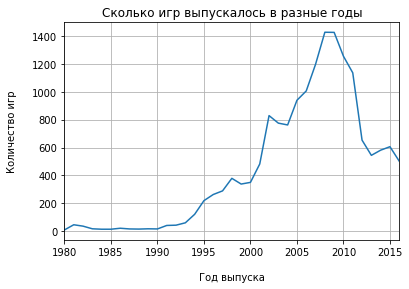

In [21]:
# построим график распределения выпуска игр по годам

df_games.groupby('year_of_release')['name'].count().plot(grid=True)
plt.title('Сколько игр выпускалось в разные годы')
plt.xlabel('Год выпуска', labelpad = 15)
plt.ylabel('Количество игр', labelpad = 15);

До 2000 года игр выпускалось мало: от единиц до нескольких сотен. С 2002 количество игр увеличилось в 2 раза и продолжало расти до 2009 года. Затем очередной спад.

Наиболее интересные для нас периоды: с 2000 по 2016 годы.

### Как менялись продажи по платформам

1. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. 
1. Определим, за какой характерный срок появляются новые и исчезают старые платформы.

In [22]:
# отсортируем платформы по убыванию суммарных продаж

df_platform = (df_games
               .groupby('platform').agg({'total_sales': 'sum'})
               .sort_values(by = 'total_sales', ascending = False)
              )

# проверяем
display(df_platform)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [23]:
# ограничимся теми платформами, где суммарные продажи превышают 700 млн.

top_platform = df_platform[df_platform['total_sales'] > 700]
display(top_platform)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58


In [24]:
# сформируем датасет с данными только по выбранным платформам

df_top_platform = df_games.query('platform in @top_platform.index')

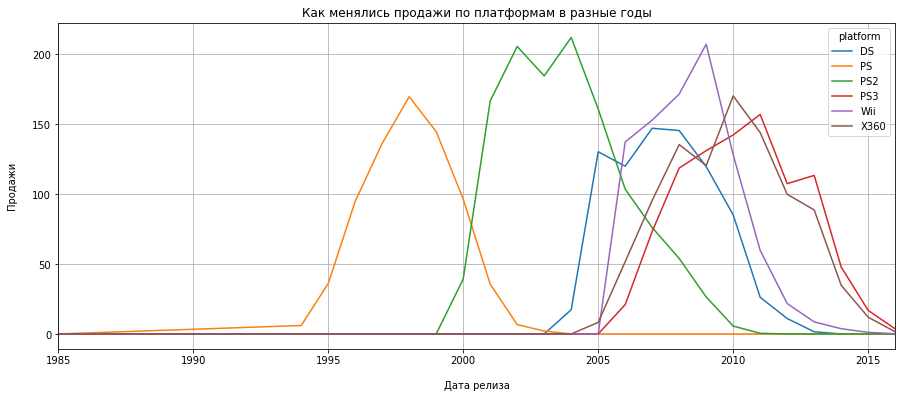

In [25]:
# построим сводную таблицу с распределением продаж по платформам по годам

top_platform_sales = df_top_platform.pivot_table(
                        index='year_of_release', 
                        columns='platform', 
                        values='total_sales', 
                        aggfunc='sum').fillna(0)

# на основе полученной таблицы можем построить график распределения продаж по платформам по годам

top_platform_sales.plot(grid=True, figsize=(15, 6))
plt.title('Как менялись продажи по платформам в разные годы')
plt.xlabel('Дата релиза', labelpad = 15)
plt.ylabel('Продажи', labelpad = 15)
plt.show();

Видим, что платформы в среднем "живут" по 10 лет.

PS, PS2 и DS уже отжили свой срок, с 2014 года их на рынке нет.

### Отфильтруем данные за соответствующий актуальный период 

Определим его в результате исследования предыдущих вопросов:

1. На первом шаге мы выделили диапазон с 2000 по 2016 годы.
1. Если смотреть по платформам, то можно определить 2013 год в качестве границы, когда старые платформы ушли с рынка.

Ограничим актуальный период диапазоном с 2013 по 2016 годы, он поможет нам определиться со стратегией на 2017 год.

In [26]:
# делаем срез, оставляя в датасете только данные игр, вышедших на рынок с 2013 года

df_games_actual = df_games.query('year_of_release >= 2013')
df_games_actual

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


### Какие платформы лидируют по продажам, растут или падают

Выберем потенциально прибыльные платформы.

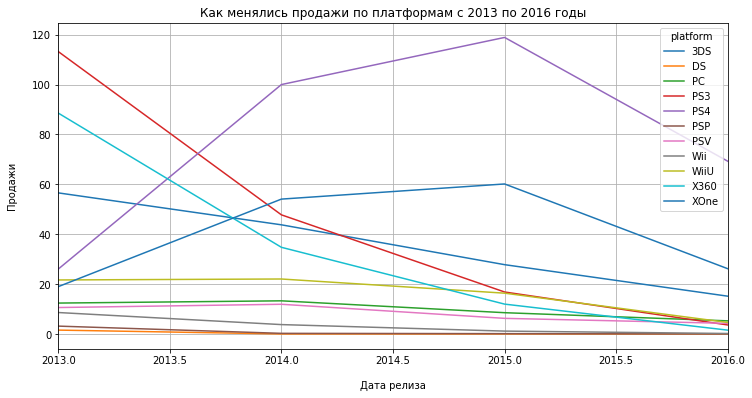

In [27]:
# посмотрим на продажи по платформам за определённый нами на прошлом шаге актуальный период

platform_sales = df_games_actual.pivot_table(
                        index='year_of_release', 
                        columns='platform', 
                        values='total_sales', 
                        aggfunc='sum').fillna(0)

# на основе полученной таблицы можем построить график распределения продаж по платформа за последние годы

platform_sales.plot(grid=True, figsize=(12, 6))
plt.title('Как менялись продажи по платформам c 2013 по 2016 годы')
plt.xlabel('Дата релиза', labelpad = 15)
plt.ylabel('Продажи', labelpad = 15)
plt.show();

Видим, что в последние 3 года по продажам лидируют PS4, XOne и 3DS. Лидировавшие в 2013 году PS3 и X360 c 2014 года стали резко терять позиции.

К 2016 году продажи по всем платформам снизились, но тройка лидиров по-прежнему отрывается по суммарным продажам от всех остальных.

Можем определить в качестве потенциально прибыльных платформ на следующий год: PS4, XOne и 3DS.

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам

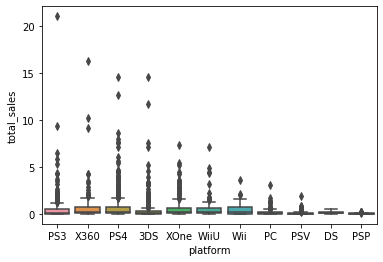

In [28]:
sns.boxplot(y="total_sales", x="platform", data=df_games_actual);

Видим на графике много выбросов, которые мешают рассмотреть сами ящики. Попробуем сначала отрезать выбросы свыше 5 млн.

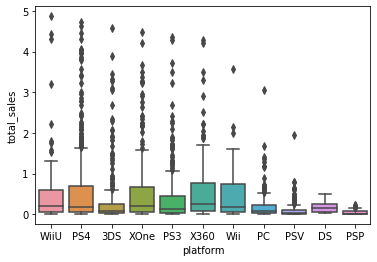

In [29]:
sns.boxplot(y="total_sales", x="platform", data=df_games_actual[df_games_actual['total_sales'] < 5]);

Выбросы по-прежнему мешают. Отрежем их ещё раз, на этот раз возьмём в качестве границы 1 млн.

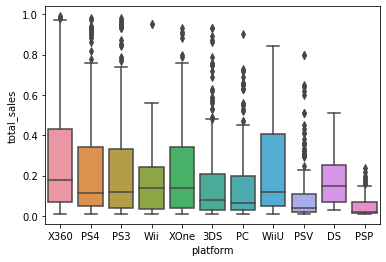

In [30]:
sns.boxplot(y="total_sales", x="platform", data=df_games_actual[df_games_actual['total_sales'] < 1]);

Самый большой межквартильный размах по продажам на платформах X360, XOne, WiiU, PS3 и PS4. Это значит, что 75% их продаж лежат ниже отметки ~ 0,375-0,4 млн - выше, чем у остальных платформ.

У них же одни из самых высоких медиан. Также высокая медиана у платформы DS. Т.е. половина суммарных продаж не опускается ниже этих отметок - тоже хороший показатель прибыльности платформы.

### Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков

Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

**Сначала нужно почистить датасет**

In [31]:
# как мы помним, в оценках у нас было достаточно много пропусков - уберём их, чтобы не мешали выяснять зависимости
df_games_actual_score = df_games_actual.dropna(subset = ['critic_score', 'user_score']) 

# проверяем датасет на наличие пропусков
df_games_actual_score.isnull().sum()

name                0
platform            0
year_of_release     0
genre               0
na_sales            0
eu_sales            0
jp_sales            0
other_sales         0
critic_score        0
user_score          0
rating             34
total_sales         0
dtype: int64

Нам нужно понять, как отзывы влияют на продажи внутри одной популярной платформы. Возьмём выбранную ранее в качестве перспективной платформу PS4, у которой в том числе и хорошие продажи.

In [32]:
df_games_actual_score_ps4 = df_games_actual_score.query('platform == "PS4"')

**Построим матрицу корреляции и диаграммы рассеяния для отзывов и продаж**

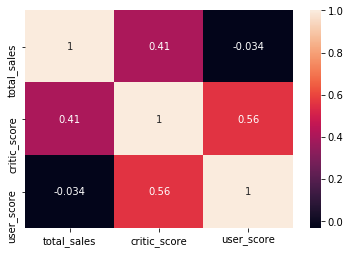

In [33]:
# выделим нужные параметры в отдельный список: суммарные продажи, отзывы критиков и пользователей
parameters = ['total_sales', 'critic_score', 'user_score']

# построим матрицу корреляции
sns.heatmap(df_games_actual_score_ps4[parameters].corr(), annot=True);

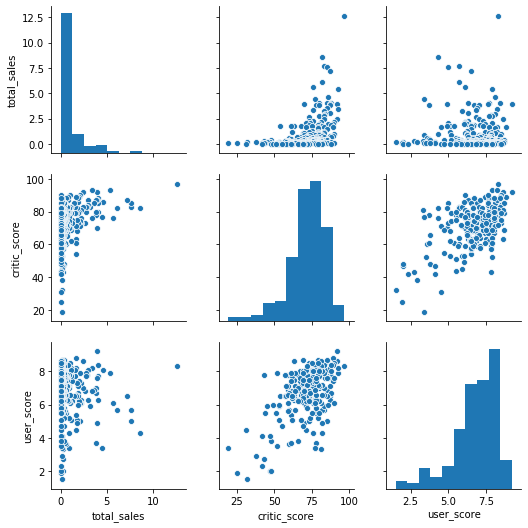

In [34]:
# построим диаграммы рассеяния
sns.pairplot(df_games_actual_score_ps4[parameters]);

***Выводы***

1. У продаж и отзывов критиков есть слабая прямая зависимость. Она возрастает в процессе увеличения оценок.
1. У продаж и отзывов пользователей очень слабая зависимость, точнее, её практически нет. На диаграмме рассеяния можно видеть, что не смотря на увеличение оценок, диапазон суммарных продаж практически не меняется, а также есть высокие продажи у низкооцениваемых и середнячковых игр по мнению пользователей.
1. Интересно, что на графике также можно увидеть прямую среднюю зависимость между двумя видами оценок: критики - тоже люди и своего рода пользователи :)

Можно сделать вывод, что ни отзывы критиков, ни пользователей не влияют на продажи игр на платформе PS4.

### Соотнесём выводы предыдущего шага с продажами игр на других платформах

Посмотрим на корреляции между продажами и отзывами в целом на всех платформах.

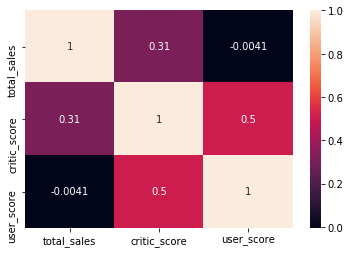

In [35]:
# построим матрицу корреляции для датасета со всеми платформами
sns.heatmap(df_games_actual_score[parameters].corr(), annot=True);

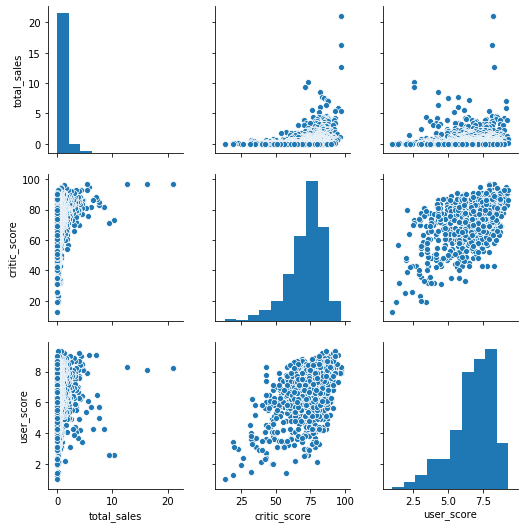

In [36]:
# построим диаграммы рассеяния
sns.pairplot(df_games_actual_score[parameters]);

***Выводы***

Мы получили такие же выводы.
Т.е. на продажи практически не влияют не только отзывы, но и популярность платформы.

**Как влияют на продажи оценки пользователей на других популярных платформах**

На предыдущих шагах мы выделили перспективные платформы и платформы, лидирующие по продажам. 

Сформируем их в отдельный список. PS4 из него уберём, т.к. рассмотрели выше:

In [37]:
df_games_actual_score_platform = ['X360', 'XOne', 'WiiU', 'PS3', '3DS']

X360


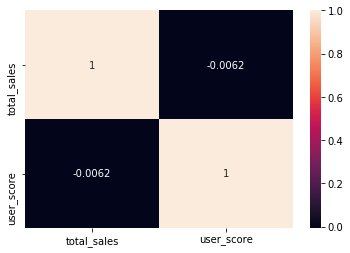

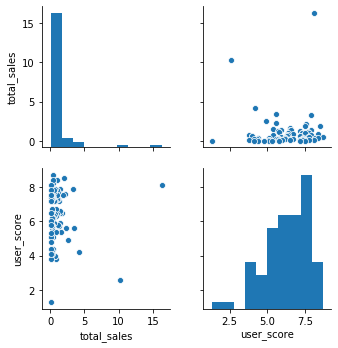

XOne


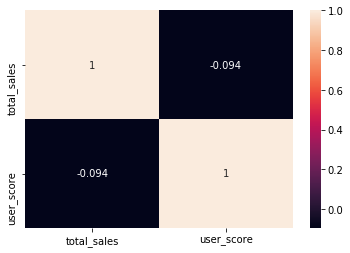

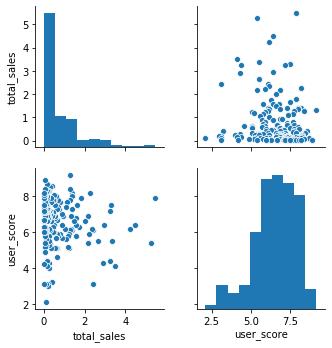

WiiU


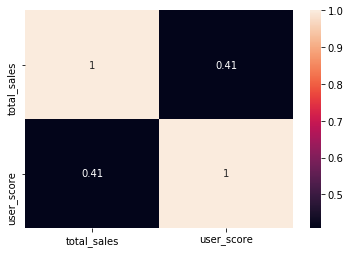

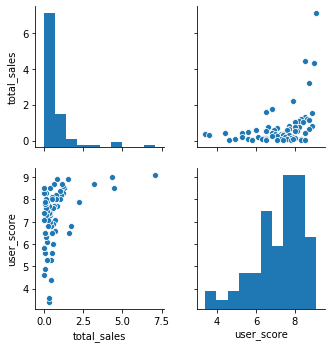

PS3


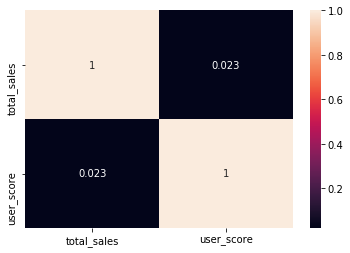

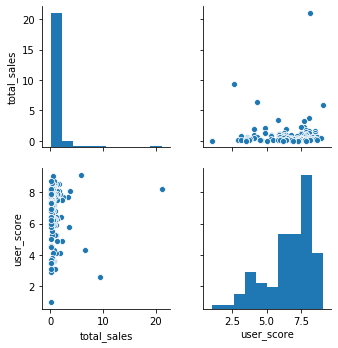

3DS


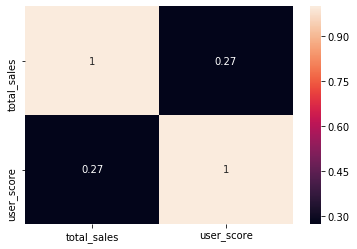

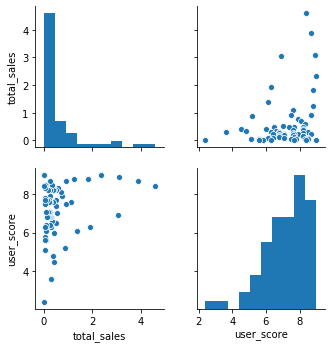

In [38]:
# выделим продажи и оценки пользователей в список параметров, на взаимосвязь которых будем смотреть
parameters_user = ['total_sales', 'user_score']

# переберём циклом все платформы и рассмотрим влияние отзывов пользователей на продажи
for platform in df_games_actual_score_platform:
    print(platform)
    
    # фильтруем датасет по платформам
    platform_pop = df_games_actual_score.query('platform == @platform')
    
    # строим матрицы корреляции и рассеяния для каждой платформы
    sns.heatmap(platform_pop[parameters_user].corr(), annot=True)
    sns.pairplot(platform_pop[parameters_user])
    plt.show()

***Выводы***

Видим, что слабое прямое влияние на продажи оценки пользователей оказывают на платформах WiiU и 3DS.

### Посмотрим на общее распределение игр по жанрам

1. Что можно сказать о самых прибыльных жанрах.
1. Выделяются ли жанры с высокими и низкими продажами.

In [39]:
# построим сводную таблицу по жанрам и суммарным продажам, дополнительно отсортируем продажи по убыванию

genre_sales = df_games_actual.pivot_table(index = 'genre',
                                          values = 'total_sales', 
                                          aggfunc = 'sum').sort_values('total_sales',
                                                                       ascending = False)

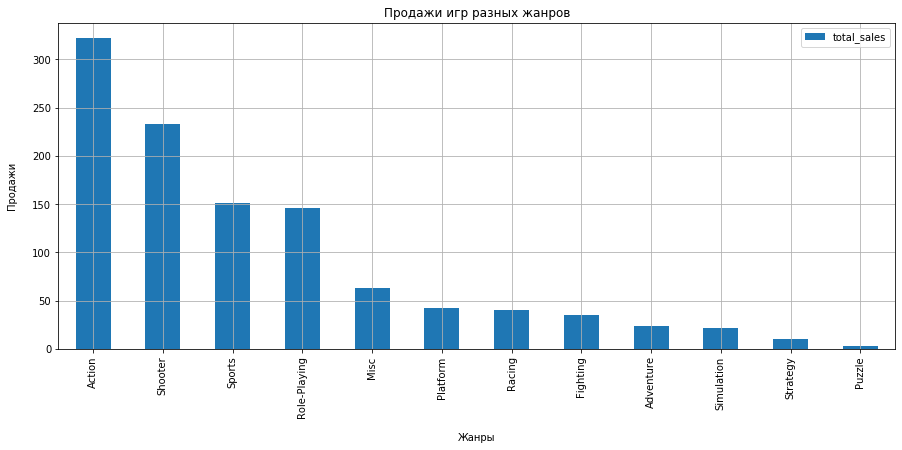

In [40]:
# на основе полученной таблицы построим график продаж игр разных жанров

genre_sales.plot(kind='bar', grid=True, figsize=(15, 6))
plt.title('Продажи игр разных жанров')
plt.xlabel('Жанры', labelpad = 15)
plt.ylabel('Продажи', labelpad = 15)
plt.show();

***Выводы***

У нас 4 явных фаворита: это игры в жанрах экшен, шутеры, спортивные и ролевые.
Их суммарные продажи составляют от 150 до 330 млн. долларов.

Меньше всего денег собирают квесты, симуляторы, стратегии и головоломки.

**Определим средний чек продаж по жанрам**

In [41]:
# определим средний чек продаж по жанрам: построим сводную таблицу по жанрам и средним продажам
# также дополнительно отсортируем продажи по убыванию

genre_sales_mean = df_games_actual.pivot_table(index = 'genre',
                                          values = 'total_sales', 
                                          aggfunc = 'mean').sort_values('total_sales',
                                                                       ascending = False)

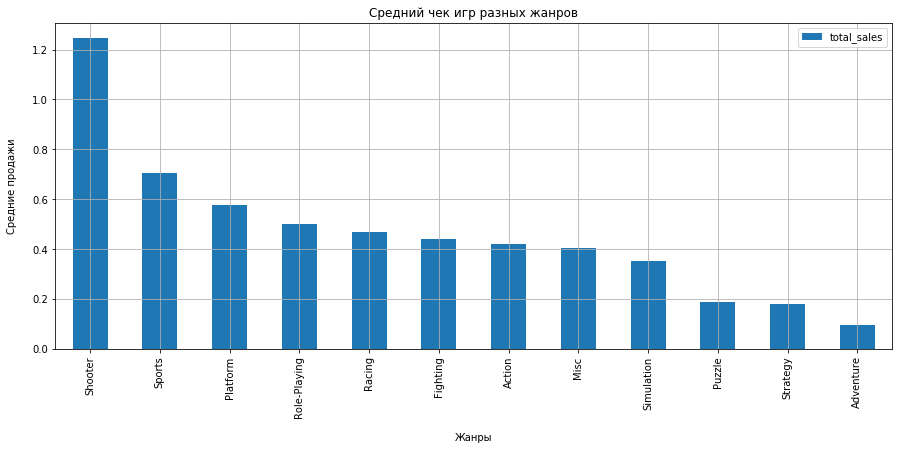

In [42]:
# на основе полученной таблицы построим график средних продаж игр разных жанров

genre_sales_mean.plot(kind='bar', grid=True, figsize=(15, 6))
plt.title('Средний чек игр разных жанров')
plt.xlabel('Жанры', labelpad = 15)
plt.ylabel('Средние продажи', labelpad = 15)
plt.show();

***Выводы***

Жанр экшен по среднему чеку перешёл в группу средних продаж.
Лидерство за шутерами, спортивными, ролевыми (они также в лидерах по суммарным продажам) и платформенными играми.

По среднему чеку меньше всего денег так же, как и по суммарным продажам, собирают квесты, симуляторы, стратегии и головоломки.

## Шаг 4. Портрет пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
1. Самые популярные платформы (топ-5). 
1. Самые популярные жанры (топ-5). 
1. Влияет ли рейтинг ESRB на продажи в отдельном регионе.

**Найдём топ-5 платформ по продажам в интересующих регионах и посмотрим на их графики продаж**

In [43]:
# выделим регионы в отдельный список

regions = ['na_sales', 'eu_sales', 'jp_sales']

Регион продаж и его топ-5 платформ:  na_sales ['PS4', 'XOne', 'X360', 'PS3', '3DS']
Регион продаж и его топ-5 платформ:  eu_sales ['PS4', 'PS3', 'XOne', 'X360', '3DS']
Регион продаж и его топ-5 платформ:  jp_sales ['3DS', 'PS3', 'PSV', 'PS4', 'WiiU']


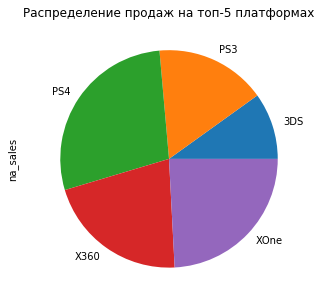

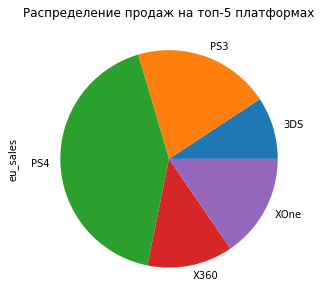

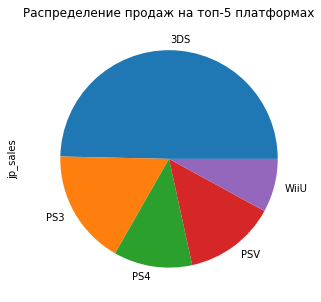

In [44]:
# переберём в цикле каждый регион: сначала определим его топ-5 платформ, а затем построим график продаж

for region in regions:
    top_5 = (df_games_actual.groupby('platform', as_index = False)
         .agg({region: 'sum'})
         .sort_values(region, ascending = False)
         .head(5)['platform'].tolist())
    print('Регион продаж и его топ-5 платформ: ', region, top_5)
    
    # фильтруем датасет по платформам из топ-5
    platforms_region = df_games_actual.query('platform == @top_5')
    
    # строим круговую диаграмму на основе сводной таблицы по продажам на платформах из топ-5
    platforms_region.pivot_table(index = 'platform',
                        values = region, aggfunc = 'sum').plot(kind='pie', subplots=True, figsize=(5, 5), legend=False)
    plt.title('Распределение продаж на топ-5 платформах');
    plt.ylabel(region, labelpad = 15)

***Выводы***

В **Северной Америке** самые высокие продажи на платформах PS4 и XOne, на третьем месте - платформа X360.

В **Европе** также с сильным отрывом по продажам лидирует PS4, за ней идут PS3 и XOne. 

Что в Америке, что в Европе сильно ниже продажи на платформе 3DS.

Интересно, что в **Японии** при этом 3DS - абсолютный лидер продаж, на втором месте - PS3, а на третьем - PSV, которая не вошла в топ-5 в Америке и Европе.

**Найдём топ-5 популярных жанров игр в интересующих регионах и посмотрим на разницу в предпочтениях пользователей**

Регион продаж и его топ-5 игровых жанров:  na_sales ['Action', 'Shooter', 'Sports', 'Role-Playing', 'Misc']
Регион продаж и его топ-5 игровых жанров:  eu_sales ['Action', 'Shooter', 'Sports', 'Role-Playing', 'Racing']
Регион продаж и его топ-5 игровых жанров:  jp_sales ['Role-Playing', 'Action', 'Misc', 'Fighting', 'Shooter']


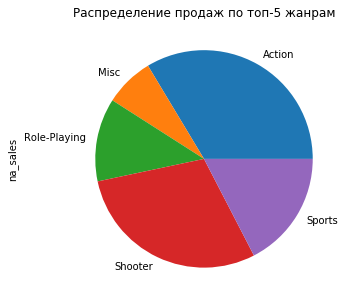

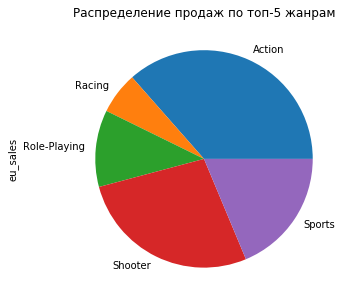

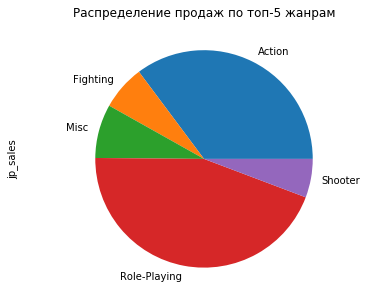

In [45]:
# переберём в цикле каждый регион, сначала определим его топ-5 любимых жанров пользователей, а затем построим график продаж

for region in regions:
    top_5 = (df_games_actual.groupby('genre', as_index = False)
         .agg({region: 'sum'})
         .sort_values(region, ascending = False)
         .head(5)['genre'].tolist())
    print('Регион продаж и его топ-5 игровых жанров: ', region, top_5)
    
    # фильтруем датасет по жанрам из топ-5
    genre_region = df_games_actual.query('genre == @top_5')
    
    # строим круговую диаграмму на основе сводной таблицы по продажам игр с жанрами из топ-5
    genre_region.pivot_table(index = 'genre',
                        values = region, aggfunc = 'sum').plot(kind='pie', subplots=True, figsize=(5, 5), legend=False)
    plt.title('Распределение продаж по топ-5 жанрам');
    plt.ylabel(region, labelpad = 50)

***Выводы***

По предпочитаемым жанрам игр **Северная Америка** и **Европа** ведут себя как близнецы :) 

Экшены и шутеры - вне конкуренции. Регионы разошлись в предпочтениях только по пятой позиции в топ-5: американцам больше нравятся смешанные игры (без понятия, что такое Misc)), а европейцам - гонки.

**Японцы** тоже любят экшен, но всё-таки он на втором месте, на первом - ролевые игры. Остальные три жанра (бои, шутеры и смешанные) собирают продажи примерно на одном уровне, и он гораздо ниже чем первые два в топе.

**Определим, влияет ли рейтинг ESRB на продажи в отдельном регионе**

In [46]:
# ранее мы не избавлялись от строк с пропущенным рейтингом, сейчас нужно это сделать, чтобы пропуски не мешали

df_games_actual_rating = df_games_actual.dropna(subset = ['rating']) 

In [47]:
# проверим разницу в категориях рейтингов в отфильтрованном датасете (данные с 2014 года) и первоначальном

print(df_games_actual_rating['rating'].value_counts())
print()
print(df_games['rating'].value_counts())

M       369
T       333
E       302
E10+    252
Name: rating, dtype: int64

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64


Видим, что по сравнению с изначальными данными у нас больше нет игр с рейтингами EC, K-A, AO, RP. Рассмотрим их поподробней:
- рейтинг K-A ("Kids to Adults") в 1998 стал рейтингом E, он уже устаревший,
- рейтинг RP («Rating Pending») означает, что игра была отправлена в ESRB и ожидает присвоения рейтинга,
- рейтинги АO («Adults Only 18+») и EC («Early childhood») были проставлены только у 9 игр, на весь массив данных они влиять не могут.

Хоть мы и потеряли 4 вида рейтинга, но они не будут влиять на финальные результаты по рассмотренным выше причинам. Можем продолжать работать с датасетом с актуальным временным периодом.

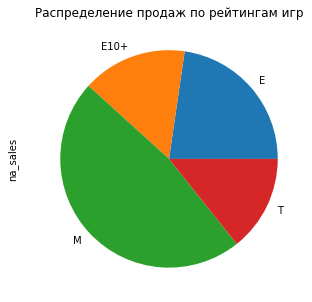

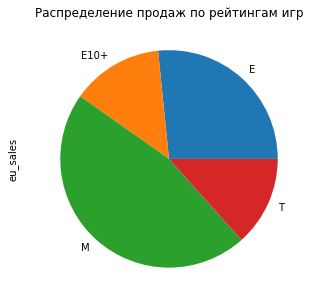

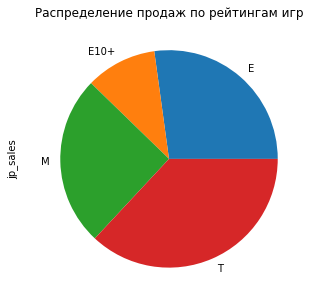

In [48]:
# переберём в цикле каждый регион и построим диаграммы продаж игр в зависимости от рейтинга

for region in regions:
    df_games_actual_rating.pivot_table(index = 'rating',
                        values = region, aggfunc = 'sum').plot(kind='pie', subplots=True, figsize=(5, 5), legend=False)
    plt.title('Распределение продаж по рейтингам игр');
    plt.ylabel(region, labelpad = 15)

***Выводы***

И снова **Северная Америка** сошлась во мнении с **Европой**. Разница есть разве что в самих цифрах продаж, но доли примерно одинаковые: игры с рейтингом M («Mature» - для взрослых не младше 17 лет) бьют рекорды продаж, в два раза меньше зарабывают игры с рейтингом E («Everyone»), у оставшихся двух рейтингов игр продажи примерно на одном уровне в районе 45-50 млн. долларов.

**Япония** опять отличилась: там больше всего покупают игры с рейтингом T («Teen»), за ними почти на одинаковом уровне продаж держатся игры с рейтингами M и E. Похоже, что в Японии игровую индустрию захватили подростки :)

Игры с рейтингом E10+ («Everyone 10 and older») во всех трёх регионах показывают низкие продажи. 

## Шаг 5. Проверим гипотезы

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
1. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Первая гипотеза

- Нулевая гипотеза: **Средние пользовательские рейтинги платформ Xbox One и PC равны.**
- Альтернативная гипотеза: **Средние пользовательские рейтинги платформ Xbox One и PC различаются**

Будем использовать датасет df_games_actual_score, который ранее мы почистили от пропусков и значений рейтинга "tbd".

In [49]:
# сформируем два датасета: пользовательские оценки для двух интересующих нас платформ

platform_score_xone = df_games_actual_score.query('platform == "XOne"')['user_score']
platform_score_pc = df_games_actual_score.query('platform == "PC"')['user_score']

Сначала проверим, одинаковая ли дисперсия у выборок с оценками по двум платформам (нулевая гипотеза).

In [50]:
# используем для проверки гипотезы критерий Левене

from scipy.stats import levene

if (levene(platform_score_xone, platform_score_pc)[1] < 0.05):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')    

Отвергаем нулевую гипотезу


В соответствии с критерием Левене мы отвергли гипотезу о равных дисперсиях двух выборок.

Проверим основную гипотезу о равенстве средних пользовательских рейтингов на двух платформах с помощью теста Стьюдента. Можем использовать его, т.к. количество наблюдений более 30.

In [51]:
# определим критический уровень статистической значимости равным 0.05

alpha = 0.05

# применим метод scipy.stats.ttest_ind и определим уровень значимости p-value

results = st.ttest_ind(platform_score_xone, platform_score_pc, equal_var = False)
print('p-значение: ', results.pvalue)

# условие для проверки гипотезы

if (results.pvalue < 0.05):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')  

p-значение:  0.17882648263401307
Не получилось отвергнуть нулевую гипотезу


***Пояснение***

Нулевую гипотезу о равенстве средних пользовательских рейтингов платформ Xbox One и PC отвергнуть не получилось. 

Рейтинги игр для этих двух платформ примерно равны.

### Вторая гипотеза

- Нулевая гипотеза: **Средние пользовательские рейтинги жанров Action и Sports равны.**
- Альтернативная гипотеза: **Средние пользовательские рейтинги жанров Action и Sports разные.**

In [52]:
# снова сформируем два датасета: пользовательские оценки для двух интересующих нас жанров игр

genre_score_action = df_games_actual_score.query('genre == "Action"')['user_score']
genre_score_sports = df_games_actual_score.query('genre == "Sports"')['user_score']

Аналогично сначала проверим, одинаковая ли дисперсия у выборок с оценками по двум жанрам (нулевая гипотеза).

In [53]:
# используем для проверки гипотезы критерий Левене

if (levene(genre_score_action, genre_score_sports)[1] < 0.05):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')  

Не получилось отвергнуть нулевую гипотезу


В соответствии с критерием Левене не получилось отвергнуть гипотезу о равных дисперсиях двух выборок - учтём это в следующем тесте.

Проверим основную гипотезу о равенстве средних пользовательских рейтингов двух жанров с помощью теста Стьюдента.

In [54]:
# определим критический уровень статистической значимости равным 0.05

alpha = 0.05

# применим метод scipy.stats.ttest_ind и определим уровень значимости p-value

results = st.ttest_ind(genre_score_action, genre_score_sports, equal_var = True)
print('p-значение: ', results.pvalue)

# условие для проверки гипотезы

if (results.pvalue < 0.05):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')  

p-значение:  1.684099430689953e-16
Отвергаем нулевую гипотезу


In [55]:
# т.к. нулевая гипотеза о равенстве оценок отвергнута, определим, какой жанр оценивается пользователями выше

if  pd.Series(genre_score_action).mean() > pd.Series(genre_score_sports).mean():
    print('Жанр Action получает более высокий рейтинг.')
else:
    print('Жанр Sports получает более высокий рейтинг.')   

Жанр Action получает более высокий рейтинг.


***Пояснение***

Нулевая гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports отвергнута. 

Жанр Action оценивается пользователями выше и получает более высокий рейтинг, чем жанр Sports.

## Шаг 6. Общий вывод



**Потенциально прибыльные платформы.**

Платформы в среднем "живут" по 10 лет. PS, PS2 и DS уже отжили свой срок.

Можем определить в качестве потенциально прибыльных платформ на следующий год: PS4, XOne и 3DS.

Также хорошие суммарные продажи у платформа: X360, WiiU, PS3. 


**Влияние рейтингов.**

Зависимость продаж от отзывов критиков и пользователей слабая, независимо от платформы.
Т.е. на продажи практически не влияют не только отзывы, но и популярность платформы.


**Прибыльные жанры.**

По продажам у нас 4 явных фаворита: это игры в жанрах экшен, шутеры, спортивные и ролевые. Их суммарные продажи составляют от 150 до 330 млн. долларов.

По среднему чеку жанр экшен перешёл в группу средних продаж. Лидерство за шутерами, спортивными, ролевыми (они также в лидерах по суммарным продажам) и платформенными играми.

По среднему чеку меньше всего денег так же, как и по суммарным продажам, собирают квесты, симуляторы, стратегии и головоломки.

____________________________________

### Портрет пользователя каждого региона (NA, EU, JP).

**1. Самые популярные платформы (топ-5).**

- В ***Северной Америке*** самые высокие продажи на платформах PS4 и XOne, на третьем месте - платформа X360.
- В ***Европе*** также с сильным отрывом по продажам лидирует PS4, за ней идут PS3 и XOne. 

Что в Америке, что в Европе сильно ниже продажи на платформе 3DS.

- При этом в ***Японии*** 3DS - абсолютный лидер продаж, на втором месте - PS3, а на третьем - PSV, которая не вошла в топ-5 в Америке и Европе.

**2. Самые популярные жанры (топ-5).**

- По предпочитаемым жанрам игр ***Северная Америка*** и ***Европа*** ведут себя как близнецы :) 

Экшены и шутеры - вне конкуренции. Регионы разошлись в предпочтениях только по пятой позиции в топ-5: американцам больше нравятся смешанные игры (без понятия, что такое Misc)), а европейцам - гонки.

- ***Японцы*** тоже любят экшен, но всё-таки он на втором месте, на первом - ролевые игры. Остальные три жанра (бои, шутеры и смешанные) собирают продажи примерно на одном уровне, и он гораздо ниже чем первые два в топе.

**3. Как влияет рейтинг ESRB на продажи в отдельном регионе.**

- И снова ***Северная Америка*** сошлась во мнении с ***Европой***. Разница есть разве что в самих цифрах продаж, но доли одинаковые: игры с рейтингом M («Mature» - для взрослых не младше 17 лет) бьют рекорды продаж, в два раза меньше зарабывают игры с рейтингом E («Everyone»), у оставшихся двух рейтингов игр продажи примерно на одном уровне в районе 45-50 млн. долларов.

- ***Япония*** опять отличилась: там больше всего покупают игры с рейтингом T («Teen»), за ними почти на одинаковом уровне продаж держатся игры с рейтингами M и E. Похоже, что в Японии игровую индустрию захватили подростки :)

Игры с рейтингом E10+ («Everyone 10 and older») во всех трёх регионах показывают низкие продажи. 

____________________________________

### Разница рейтингов для платформ и жанров.

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые, не смотря на то, что разница в продажах на этих платформах ощутимая (Xbox One - один из лидеров).

Средние пользовательские рейтинги жанров Action и Sports разные.
Жанр Action оценивается пользователями выше и получает более высокий рейтинг, чем жанр Sports.